In [1]:
%matplotlib notebook

In [2]:
from numpy import arange, array, concatenate, newaxis, linspace
import matplotlib.pyplot as plt

In [3]:
from moabb.datasets import BNCI2014001
from moabb.paradigms import LeftRightImagery
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from pyriemann.tangentspace import TangentSpace


def get_raw_mne_data():
    dataset = BNCI2014001()
    sessions = dataset._get_single_subject_data(subject=1)
    raw_mne = sessions['session_T']['run_1']
    return raw_mne

def get_trials_data():
    dataset = BNCI2014001()
    paradigm = LeftRightImagery()
    X, labels, _ = paradigm.get_data(dataset=dataset, subjects=[1])
    return X, labels

def plot_signal(sfreq, channels, electrode, n_seconds=2):
    time = linspace(0, n_seconds, n_seconds * sfreq).reshape((1, n_seconds * sfreq))
    fig, ax = plt.subplots()
    ax.plot(time.T, signal[channels == electrode, :n_seconds*sfreq].T, lw=0.5)
    ax.set_title("{}".format(electrode))
    ax.set_xlabel("time (s)")
    ax.set_ylabel(r"V")
    
def plot_signals(sfreq, n_seconds=1):
    time = linspace(0, n_seconds, n_seconds * sfreq).reshape((1, n_seconds * sfreq))
    fig, ax = plt.subplots()
    ax.plot(time.T, signal[:-4, :n_seconds*sfreq].T, lw=0.5, color='C0', alpha=0.3)
    ax.set_title("All electrodes")
    ax.set_xlabel("time (s)")
    ax.set_ylabel(r"V")
    
def plot_cov(cov, labels, n=5):
    right = arange(len(labels))[labels == 'right_hand'][-n:]
    left = arange(len(labels))[labels == 'left_hand'][-n:]
    fig, axes = plt.subplots(2, n)
    for i, (r, l) in enumerate(zip(right, left)):
        # plt.subplot(2, n, i+1)
        axes[0, i].imshow(cov[r])
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])
        # plt.subplot(2, n, n+i+1)
        axes[1, i].imshow(cov[l])
        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])
    axes[0, n//2].set_title("Right hand")
    axes[1, n//2].set_title("Left hand")
    plt.tight_layout()
    
def plot_cov_mean(cov, labels, n=5):
    right = arange(len(labels))[labels == 'right_hand'][-n:]
    left = arange(len(labels))[labels == 'left_hand'][-n:]
    mean_r = mean_riemann(cov[right])
    mean_l = mean_riemann(cov[left])
    fig, axes = plt.subplots(2, n+1)
    for i, (r, l) in enumerate(zip(right, left)):
        axes[0, i].imshow(cov[r])
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])
        dist = distance_riemann(cov[r], mean_r)
        axes[0, i].set_xlabel("{:g}".format(dist))
        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])
        dist = distance_riemann(cov[l], mean_l)
        axes[1, i].set_xlabel("{:g}".format(dist))
    axes[0, -1].imshow(mean_r, cmap="magma")
    axes[0, -1].set_title("Mean")
    axes[0, -1].set_xticks([])
    axes[0, -1].set_yticks([])
    axes[1, -1].imshow(mean_l, cmap="magma")
    axes[1, -1].set_xticks([])
    axes[1, -1].set_yticks([])

    axes[0, n//2].set_title("Right hand")
    axes[1, n//2].set_title("Left hand")
    plt.tight_layout()
    
def plot_cov_ts(cov, labels, n=50):
    right = arange(len(labels))[labels == 'right_hand'][-n:]
    left = arange(len(labels))[labels == 'left_hand'][-n:]
    mean_r = mean_riemann(cov[right])
    mean_l = mean_riemann(cov[left])

    ts = Pipeline([('mapping', TangentSpace(metric='riemann', tsupdate=False)),
                   ('dim_reduc', PCA(n_components=2))])
    ts.fit(concatenate((cov, mean_r[newaxis, ...],
                           mean_l[newaxis, ...])))

    C_ts = ts.transform(concatenate((cov, mean_r[newaxis, ...],
                                        mean_l[newaxis, ...])))

    fig, ax = plt.subplots(1, 1)
    ax.set_title("Tangent space")
    ax.scatter(C_ts[left, 0], C_ts[left, 1], c="C0", alpha=0.3, label=r'$C_l$')
    ax.scatter(C_ts[right, 0], C_ts[right, 1], c="C1", alpha=0.3, label=r'$C_r$')
    ax.scatter(C_ts[-2, 0], C_ts[-2, 1], c="C1",
               label=r'mean right', marker='*', s=200)
    ax.scatter(C_ts[-1, 0], C_ts[-1, 1], c="C0",
               label=r'mean left', marker='*', s=200)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend()

In [4]:
5//2

2

In [5]:
raw_mne = get_raw_mne_data()
raw_mne

<RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>

In [6]:
raw_mne.info

<Info | 8 non-empty values
 bads: []
 ch_names: Fz, FC3, FC1, FCz, FC2, FC4, C5, C3, C1, Cz, C2, C4, C6, CP3, ...
 chs: 22 EEG, 3 EOG, 1 STIM
 custom_ref_applied: False
 dig: 25 items (3 Cardinal, 22 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 26
 projs: []
 sfreq: 250.0 Hz
>

In [7]:
signal = raw_mne.get_data()
signal.shape

(26, 96735)

<IPython.core.display.Javascript object>


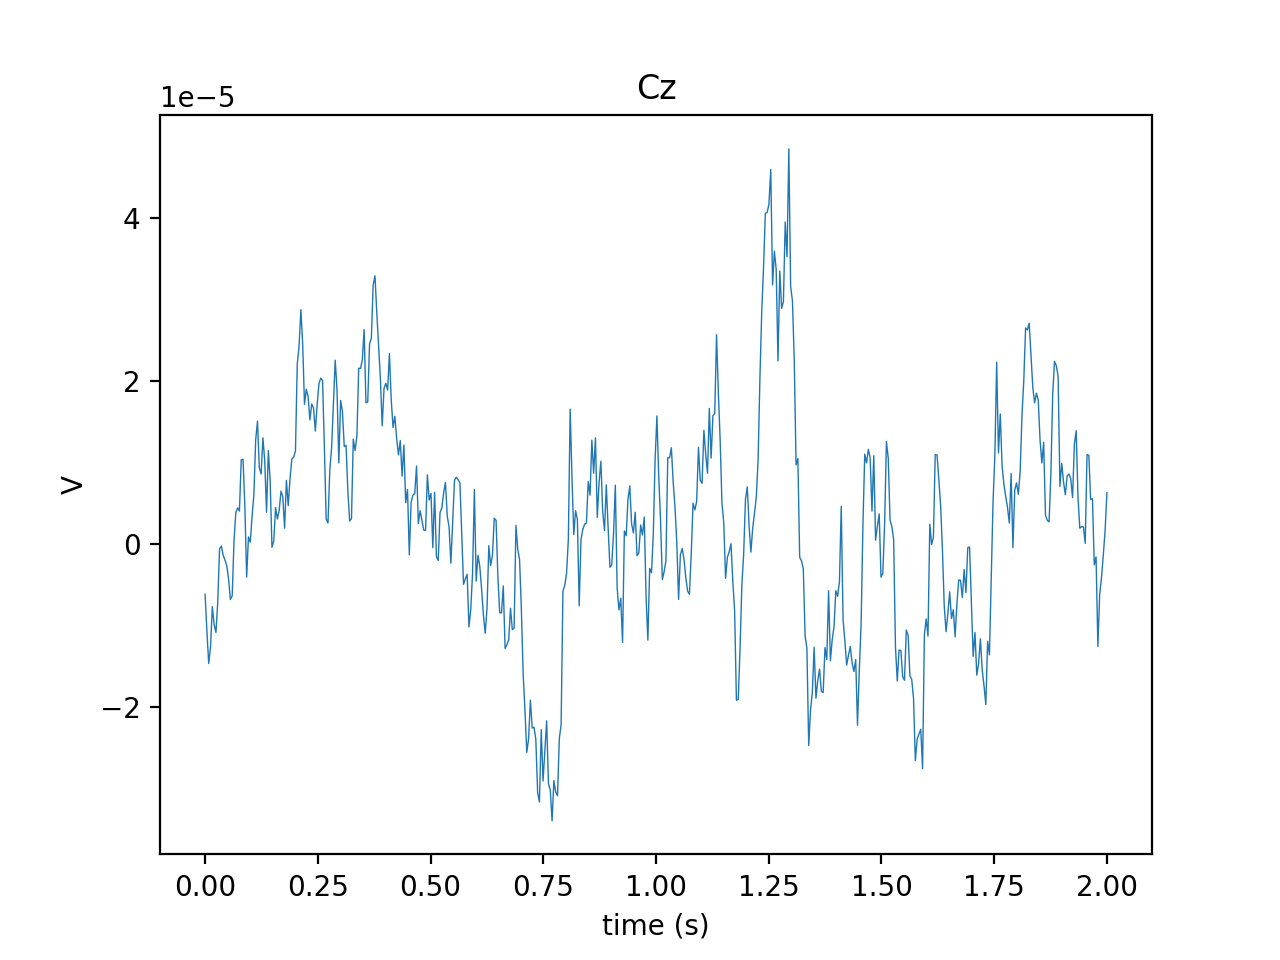

In [8]:
sfreq = int(raw_mne.info['sfreq'])
channels = array(raw_mne.info['ch_names'])
plot_signal(sfreq, channels, 'Cz', n_seconds=2)

<IPython.core.display.Javascript object>


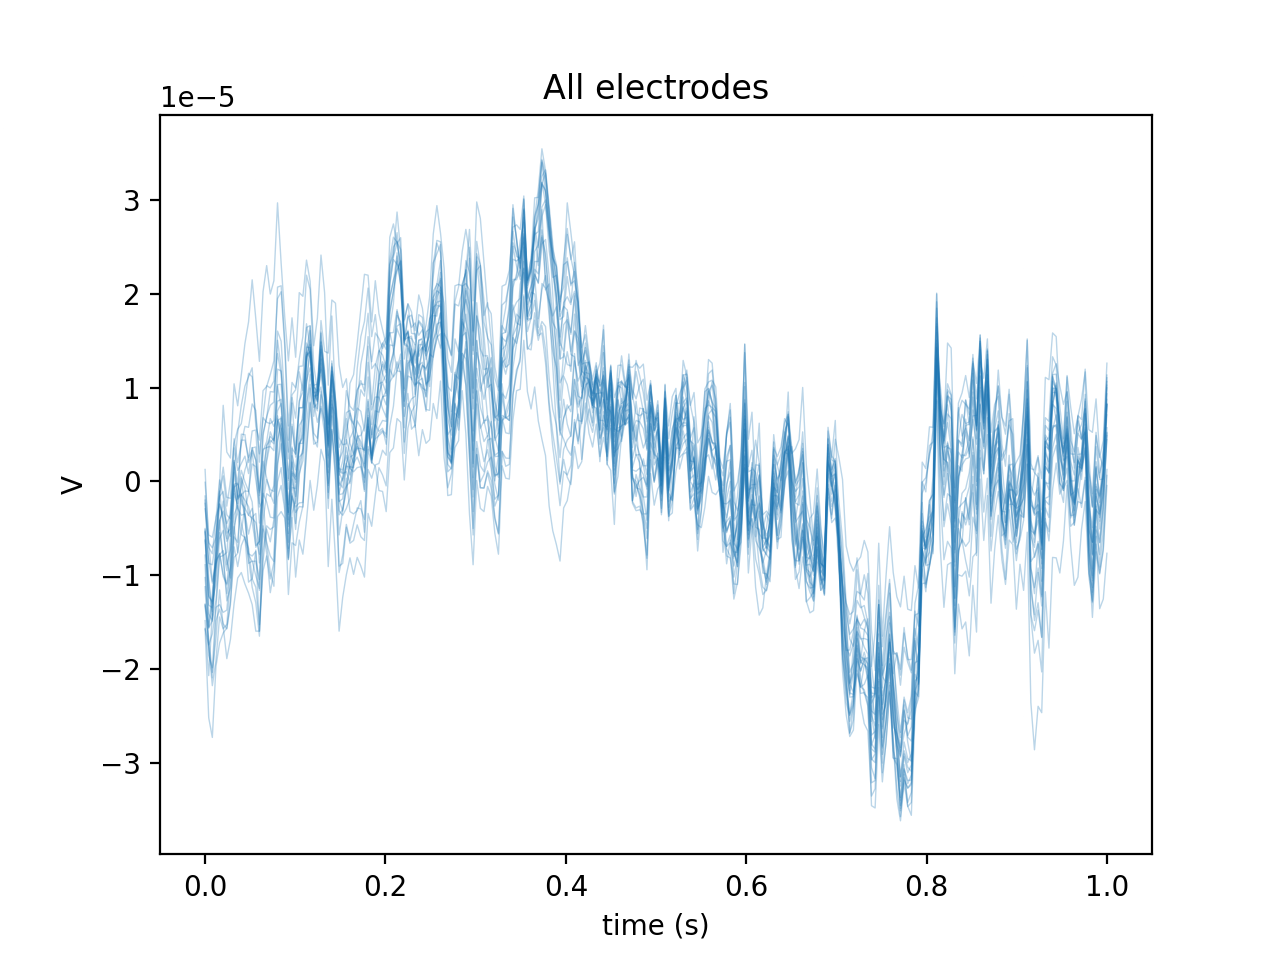

In [9]:
plot_signals(sfreq, n_seconds=1)

In [10]:
X, labels = get_trials_data()
X.shape, labels.shape

((288, 22, 1001), (288,))

In [11]:
from pyriemann.estimation import Covariances

cov = Covariances().fit_transform(X)
cov.shape

(288, 22, 22)

<IPython.core.display.Javascript object>


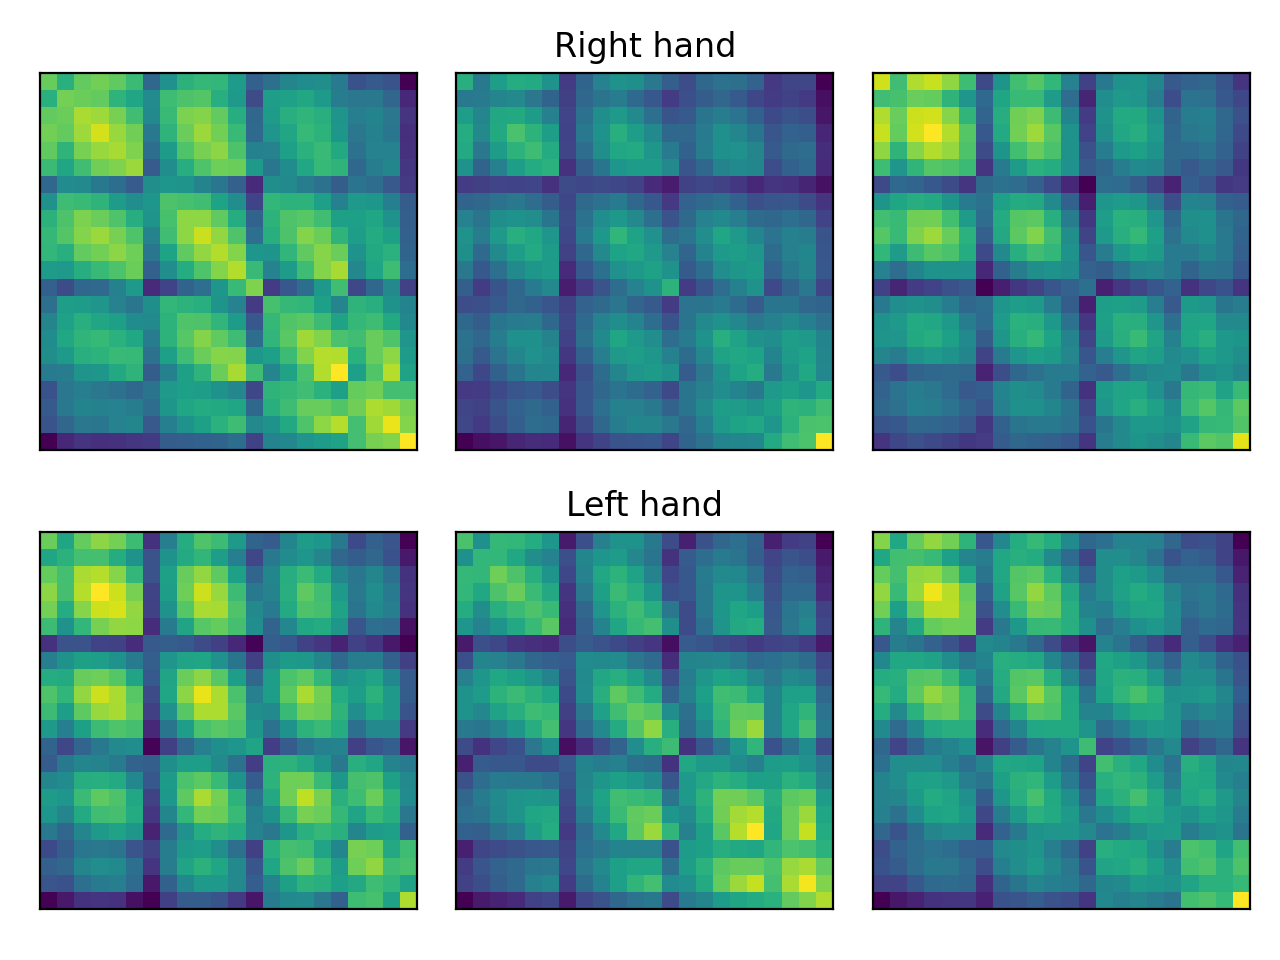

In [12]:
plot_cov(cov, labels, n=3)

In [13]:
from pyriemann.utils.mean import mean_riemann
mean = mean_riemann(cov)
mean.shape

(22, 22)

In [14]:
from pyriemann.utils.distance import distance_riemann
d = distance_riemann(cov[0], cov[1])
print(d)

3.691205440366134


<IPython.core.display.Javascript object>


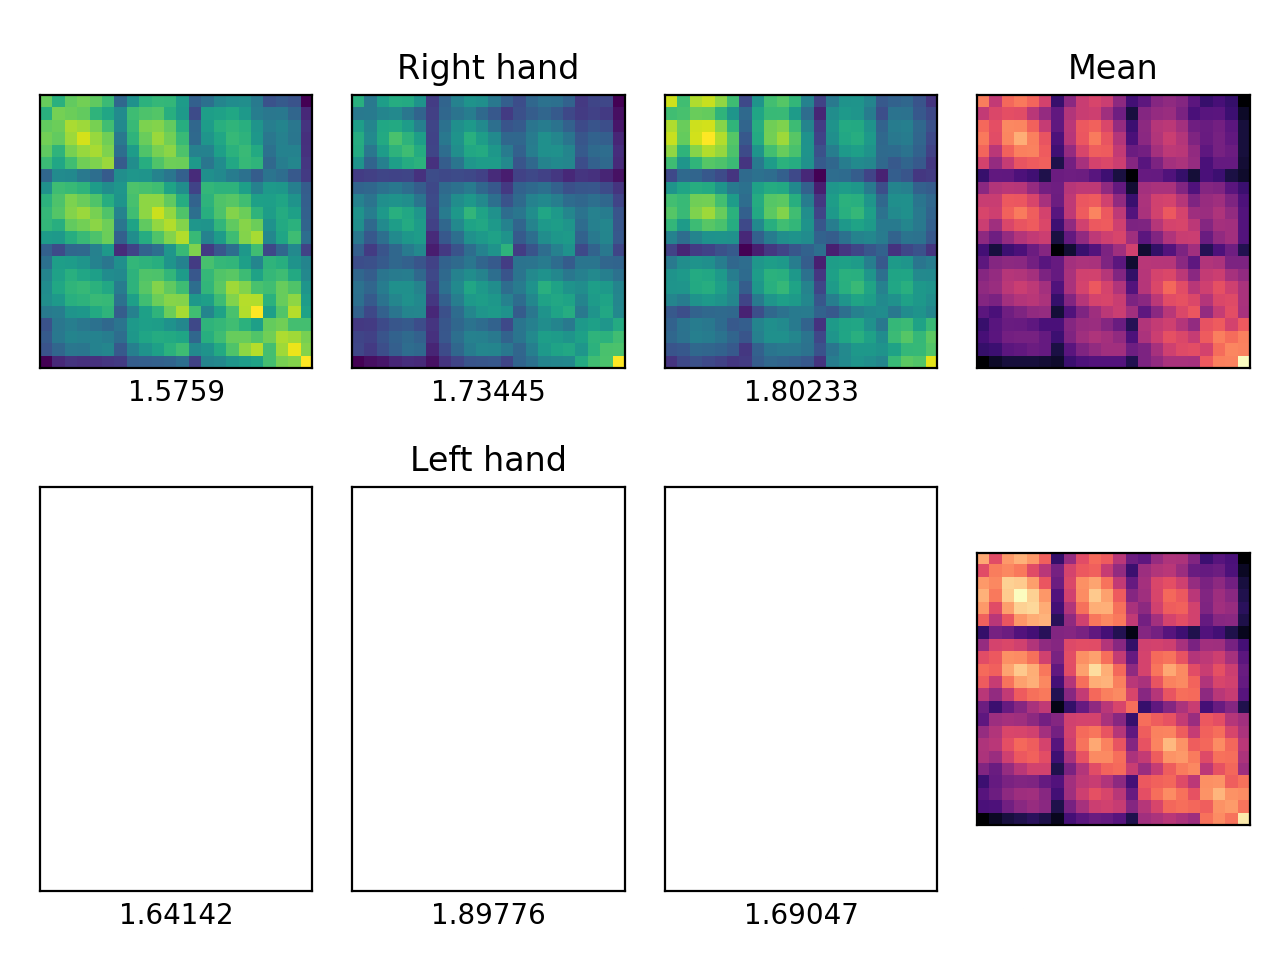

In [15]:
plot_cov_mean(cov, labels, n=3)

<IPython.core.display.Javascript object>


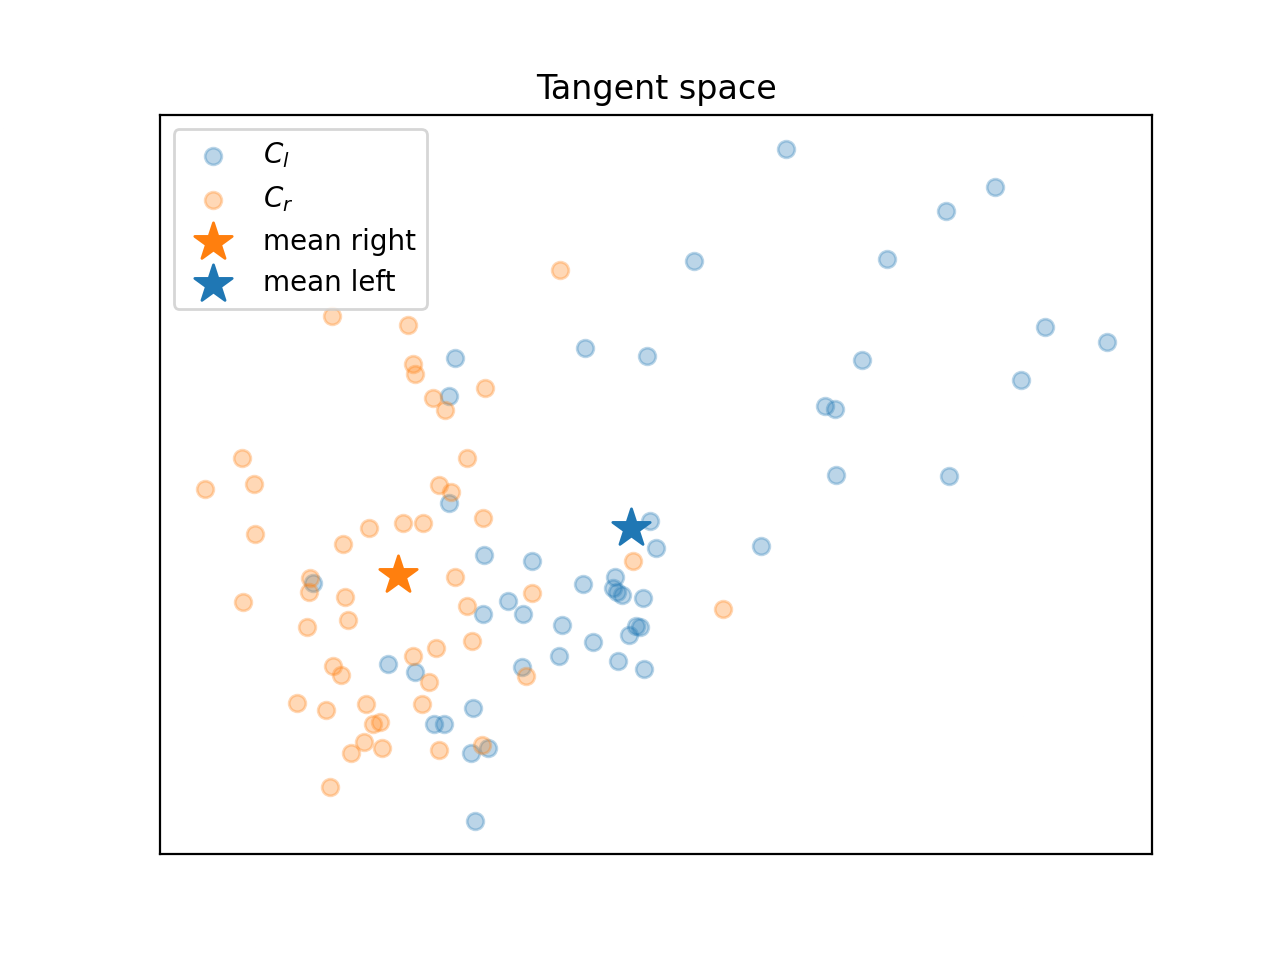

In [16]:
plot_cov_ts(cov, labels, n=50)

In [17]:
from sklearn.model_selection import train_test_split
cov_tr, cov_te, y_train, y_test = train_test_split(cov, labels, test_size=0.4, shuffle=False)

In [18]:
# train the MDM
right = arange(len(y_train))[y_train == 'right_hand']
left = arange(len(y_train))[y_train == 'left_hand']
classes = ['right_hand', 'left_hand']

mean_r = mean_riemann(cov_tr[right])
mean_l = mean_riemann(cov_tr[left])

In [19]:
# predict
y_pred = []
for c in cov_te:
    dist = [distance_riemann(c, mean_r), distance_riemann(c, mean_l)]
    y_pred.append(classes[array(dist).argmin()])
print(y_pred[:5])
print(list(y_test[:5]))

['right_hand', 'left_hand', 'left_hand', 'right_hand', 'right_hand']
['right_hand', 'left_hand', 'left_hand', 'left_hand', 'right_hand']


In [20]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred)
print ('Accuracy on test set is {:.2f}%'.format(acc))

Accuracy on test set is 0.85%


In [21]:
from pyriemann.classification import MDM

mdm = MDM(n_jobs=-1)
mdm.fit(cov_tr, y_train)
y_pred = mdm.predict(cov_te)
acc = accuracy_score(y_test, y_pred)
print ('Accuracy on test set is {:.2f}%'.format(acc))

Accuracy on test set is 0.85%


In [22]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

X, labels = get_trials_data()
mdm_ppl = make_pipeline(Covariances(), MDM(n_jobs=-1))
res = cross_validate(mdm_ppl, X, labels, scoring='accuracy', cv=5, )

print(res["test_score"])
print("5-fold accuracy is {:.2f}% +/-{:.2f}".format(res["test_score"].mean(), res["test_score"].std()))

[0.72413793 0.87931034 0.86206897 0.85964912 0.87719298]
5-fold accuracy is 0.84% +/-0.06
